In [ ]:
"""
If you want use VOC Dataset for plate's background,
Please run this code. (Linux)

"""

import sys
import os

if sys.platform  == "linux":
    if not os.path.isfile("./VOCtrainval_11-May-2012.tar"):
        %%capture
        !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
        !tar -xvf ./VOCtrainval_11-May-2012.tar
        
elif sys.platform  == "windows":
    """
    Visit https://pjreddie.com/projects/pascal-voc-dataset-mirror/
    """
    pass

In [841]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from PIL import (
    Image,
    ImageDraw,
    ImageFont,
    ImageFilter
)

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


class LPGenerator:
    def __init__(
        self,
        lp_width: int,
        lp_height: int,
        font_list: list,
        char_list: list,
        image_mode: str="RGBA",
        layout: str = "nnc nnnn",
        background: tuple=None
    ):
        super(LPGenerator, self).__init__()
        
        self.w = lp_width
        self.h = lp_height
        self.fonts = font_list
        self.chars = char_list
        self.image_mode = image_mode
        self.layout = layout.lower()
        
        if background == None:
            bg_val = list()
            for _ in range(len(self.image_mode)): bg_val.append(255)
            self.background = tuple(bg_val)
        
        else: self.background = background
        
        
    def set_background(
        self,
        background: tuple
    ):
        self.background = background
        
        return None
        
        
    def generate_hex(
        self,
        _min: int=0,
        _max: int=255,
        size: int=3
    ):
        _hex = ""
        for _ in range(size):
            hex_val = hex(random.randint(_min, _max))[2:]
            
            if len(hex_val) == 1: hex_val = "0" + hex_val
                
            _hex += hex_val
        
        return _hex
        
    
    def generate_text(
        self,
        img: Image=None,
        text: str=None,
        text_color: str=None,
        font: ImageFont=None,
        hex_min: int=10,
        hex_max: int=50,
        pad_x: int=0,
        pad_y: int=0
    ):
        
        if img == None:
            img = Image.new(self.image_mode, (self.w, self.h), self.background)
            
        canvas = ImageDraw.Draw(img)

        if text != None:
            reg_text = text
        else:
            reg_text = ""
            for c in self.layout:
                if c == 'n': reg_text += str(random.randint(0, 9))
                elif c == 'c': reg_text += str(random.choice(self.chars))
                elif c == ' ': reg_text += ' '
                else: raise ValueError(
                    "Unknown layout value %s, please use \'n', \'c', \' ' only" % c
                )
        
        if text_color != None:
            font_hex = text_color
        else:
            font_hex = self.generate_hex(hex_min, hex_max)
        
        if self.image_mode[-1] == 'A': font_hex += "FF"
            
        if font != None:
            _font = font
        else:
            _font = random.choice(self.fonts)
        canvas.text((pad_x, pad_y), reg_text, font=_font, fill="#%s" % font_hex)
        
        return reg_text, img
    
    
    def draw_rectangle(
        self,
        image: Image, 
        hex_min: int=0,
        hex_max: int=0,
        pad_x: int=10,
        pad_y: int=3,
        width: int=3
    ):
        if image.mode != "RGB":
            raise ValueError("only RGB mode can draw rectangle (not implemented)")

        R, G, B = self.background
        bg_val = (R + G + B) / 3
        w, h = image.size
        
        canvas = ImageDraw.Draw(image)
        arr = np.array(image)

        width_mask = np.mean(arr[:, :, 0], axis=0)
        height_mask = np.mean(arr[:, :, 0], axis=1)

        width_mask[width_mask<bg_val] = 1
        width_mask[width_mask>=bg_val] = 0

        height_mask[height_mask<bg_val] = 1
        height_mask[height_mask>=bg_val] = 0

        left = np.argmax(width_mask)
        right = w - np.argmax(np.flip(width_mask))

        top = np.argmax(height_mask)
        bottom = h - np.argmax(np.flip(height_mask))
        
        ol_val = random.randint(hex_min, hex_max)

        canvas.rectangle(
            [(left - pad_x, top - pad_y), (right + pad_x, bottom + pad_y)],
            outline=(ol_val, ol_val, ol_val), width=width
        )

        return image
    
    
    def rotate(
        self,
        img: Image,
        degree_min: int=-5,
        degree_max: int=5
    ):
        return img.rotate(
            random.randint(degree_min, degree_max),
            fillcolor=self.background
        )
    
    
    def translate(
        self,
        img: Image,
        x_min: int=0,
        x_max: int=10,
        y_min: int=0,
        y_max: int=10
    ):
        return img.rotate(
            0, fillcolor=self.background,
            translate=(
                random.randint(x_min, x_max),
                random.randint(y_min, y_max))
        )
    
    
    def darken(
        self,
        img: Image,
        factor_min: int=2,
        factor_max: int=120,
    ):
        factor = random.randint(factor_min, factor_max)
        shadow = np.ones((self.h, self.w), dtype=np.float) * factor
        
        if len(self.image_mode) > 1:
            shadow = np.repeat(shadow[:, :, np.newaxis], len(self.image_mode), axis=-1)
            
        if self.image_mode[-1] == 'A':
            shadow[:, :, -1] = self.background[-1]

        img = img - shadow
        img[img<0] = 0

        return Image.fromarray(img.astype(np.uint8))
    
    
    def lighten(
        self,
        img: Image,
        strength_min: float=0.0,
        strength_max: float=0.99,
    ):
        pos_x = random.randint(0, self.w)
        pos_y = random.randint(0, self.h)

        light = random.uniform(strength_min, strength_max)

        w_l = np.linspace(0, light, num=pos_x)
        w_r = np.array(list(reversed(np.linspace(0, light, num=self.w - pos_x))))
        
        light_w = np.concatenate([w_l, w_r])

        h_l = np.linspace(0, light, num=pos_y)
        h_r = np.array(list(reversed(np.linspace(0, light, num=self.h - pos_y))))
        
        light_h = np.concatenate([h_l, h_r])

        light = np.sqrt(np.outer(light_h, light_w))  * 255

        if len(self.image_mode) > 1:
            light = np.repeat(light[:, :, np.newaxis], len(self.image_mode), axis=-1)
            
        if self.image_mode[-1] == 'A':
            light[:, :, -1] = self.background[-1]

        img = img + light
        img[img>255] = 255
        
        return Image.fromarray(img.astype(np.uint8))
        
    
    def gaussian_blur(
        self,
        img: Image,
        radius: int=1
    ): 
        return img.filter(ImageFilter.GaussianBlur(radius=radius))
    
    
    def salt_and_pepper(
        self,
        img: Image,
        threshold: float=0.005,
        _min: int=64,
        _max: int=128
    ):
        img = np.array(img)
        snp = np.random.random(img.shape)
        
        img[snp>=(1-threshold)] = _max
        img[snp<=threshold] = _min

        return Image.fromarray(img.astype(np.uint8))
    
    
    def overlay(
        self,
        foreground: Image,
        background: Image
    ):
        background = np.array(background)
        bg_h, bg_w, bg_c = background.shape
        fg_h, fg_w, fg_c = np.array(foreground).shape
        
        if (fg_h > bg_h) | (fg_w > bg_w):
            raise ValueError("Background should bigger than foreground")
        
        x = bg_w - fg_w
        y = bg_h - fg_h
        
        start_x = random.randint(0, x)
        start_y = random.randint(0, y)
        
        background = background[start_y:start_y+fg_h, start_x:start_x+fg_w]
        
        background = Image.fromarray(background.astype(np.uint8))
        
        return Image.alpha_composite(background, foreground)
    
    def cv2_normalize(
        self,
        img: Image
    ):
        img = np.array(img)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        dilated = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
        median = cv2.medianBlur(dilated, 15)
        diff = 255 - cv2.subtract(median, img)

        return cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)


    def binarize(
        self,
        img: Image,
        threshold: int=200,
        normalize: bool=True
    ):
        mode = img.mode
        img = self.cv2_normalize(img)
        
        if mode != "L":
            img = np.mean(img, axis=-1).astype('uint8')

        img[img > threshold] = 255
        img[img < threshold] = 0

        return Image.fromarray(img.astype('uint8'), "L")
    

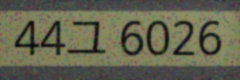

In [923]:
FONTS = [
    ImageFont.truetype("./fonts/한길체.ttf", 43),
    ImageFont.truetype("./fonts/H2GTRE.TTF", 41),
    ImageFont.truetype("./fonts/Hancom Gothic Bold.ttf", 44),
    ImageFont.truetype("./fonts/Hancom Gothic Regular.ttf", 44),
    ImageFont.truetype("./fonts/malgunbd.ttf", 43)
]

CHARS = [    # After 1996
    # 자가용
    '가', '나', '다', '라', '마',
    '거', '너', '더', '러', '머', '버', '서', '어', '저', 
    '고', '노', '도', '로', '모', '보', '소', '오', '조',
    '구', '누', '두', '루', '무', '부', '수', '우', '주',
    
    # 사업용
    '바', '사', '아', '자',
    
    # 군용
    '공', '해', '육', '합',
    
    # 기타
    '허', '하', '호', '배'
]

w, h = 240, 80
        
lp_generator = \
LPGenerator(
    lp_width=w,
    lp_height=h,
    font_list = FONTS,
    char_list = CHARS,
    image_mode="RGB",
    layout="nnc nnnn",
    background=(255, 255, 255)
)


import glob

img_list = glob.glob("../../dataset/synthesis_lp/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/*")

# bg_val = random.randint(150, 200)
lp_generator.set_background((random.randint(150, 200),
                             random.randint(150, 200),
                             random.randint(150, 200)))
reg_text, text = lp_generator.generate_text(
    hex_min=0,
    hex_max=50,
    pad_x=10,
    pad_y=5
)

text = lp_generator.translate(text)

w = random.randint(3, 20)
text = lp_generator.draw_rectangle(
    text,
    hex_min=10,
    hex_max=160,
    pad_x=20 + w,
    pad_y=10 + w,
    width=w
)

text = lp_generator.rotate(
    text,
    degree_min=-2,
    degree_max=2
)
text = lp_generator.darken(text, 1, factor_max=100)
text = lp_generator.lighten(
    text,
    strength_min=0.0,
    strength_max=0.7
)
text = lp_generator.salt_and_pepper(
    text,
    threshold=0.05,
    _min=random.randint(0, 64),
    _max=random.randint(128, 192)
)
text = lp_generator.gaussian_blur(
    text,
    radius=random.randint(0, 2)
)

text

In [924]:
from tqdm.notebook import tqdm

for _ in tqdm(range(50000)):
    lp_generator.set_background(
        (random.randint(150, 200),
         random.randint(150, 200),
         random.randint(150, 200))
    )
    reg_text, text = lp_generator.generate_text(
        hex_min=0,
        hex_max=50,
        pad_x=10,
        pad_y=5
    )

    text = lp_generator.translate(text)

    w = random.randint(3, 20)
    text = lp_generator.draw_rectangle(
        text,
        hex_min=10,
        hex_max=160,
        pad_x=20 + w,
        pad_y=10 + w,
        width=w
    )

    text = lp_generator.rotate(
        text,
        degree_min=-2,
        degree_max=2
    )
    text = lp_generator.darken(text, 1, factor_max=100)
    text = lp_generator.lighten(
        text,
        strength_min=0.0,
        strength_max=0.7
    )
    text = lp_generator.salt_and_pepper(
        text,
        threshold=0.05,
        _min=random.randint(0, 64),
        _max=random.randint(128, 192)
    )
    text = lp_generator.gaussian_blur(
        text,
        radius=random.randint(0, 2)
    )
    
    text.save(
        "../../dataset/synthesis_lp/lps-colorful/" + reg_text.replace(" ", "") + ".png"
    )